In [1]:
using Revise
using LinearAlgebra
using SparseArrays
using Pkg
using DelayDiffEq 
using Plots
using BenchmarkTools

In [2]:
using OpenQuantumSystems

┌ Info: Precompiling OpenQuantumSystems [90e503ea-487f-4e8e-81fe-8dcc9db25ac5]
└ @ Base loading.jl:1342


In [3]:
D(op1::Array, op2::Array) = abs(norm(op1 - op2))
D(x1::StateVector, x2::StateVector) = norm(x2 - x1)
D(op1::AbstractOperator, op2::AbstractOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))
D(op1::AbstractSuperOperator, op2::AbstractSuperOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))

HR = 0.01
shift = (2.0 * HR)
modes = [Mode(180., shift)]
mols = [
        Molecule([Mode(180., shift)], 3, [12500., 12700.]),
        Molecule([Mode(180., shift)], 3, [12500., 12700.])
    ]

aggCore = AggregateCore(mols)
for mol_i in 2:aggCore.molCount
    aggCore.coupling[mol_i, mol_i+1] = 50
    aggCore.coupling[mol_i+1, mol_i] = 50
end
agg = setupAggregate(aggCore)
aggCore = agg.core
aggTools = agg.tools
aggOperators = agg.operators

Ham_sys = agg.operators.Ham_sys
Ham_bath = agg.operators.Ham_bath
Ham_S = agg.operators.Ham_S
Ham_B = agg.operators.Ham_B
Ham_I = agg.operators.Ham_I
Ham_0 = agg.operators.Ham_0
Ham = agg.operators.Ham

basis = agg.tools.basis
indicesLen = agg.tools.bSize
indices = agg.tools.indices
indicesMap = agg.tools.indicesMap
FCFact = agg.tools.FCfactors
FCProd = agg.tools.FCproduct

Ham_0_lambda, Ham_0_S = eigen(Ham_0.data)
Ham_0_Sinv = inv(Ham_0_S)
Ham_0_lambda = diagm(Ham_0_lambda)

Ham_sys_lambda, Ham_sys_S = eigen(Ham_sys.data)
Ham_sys_Sinv = inv(Ham_sys_S)
Ham_sys_lambda = diagm(Ham_sys_lambda)
println("")

In [ ]:
t_max = 0.5
t_count = 200
t0 = 0.
t_step = (t_max - t0) / (t_count)
tspan = [t0:t_step:t_max;]

T = 300
mu_array = [[2, 1]]
W0_1 = thermal_state(T, [[2, 1]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_2 = thermal_state(T, [[1, 2]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_3 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
W0_4 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
a1 = indicesMap[2][1]; a2 = indicesMap[2][end]
b1 = indicesMap[3][1]; b2 = indicesMap[3][end]
W0_3.data[a1:a2, b1:b2] = W0_2.data[b1:b2, b1:b2]
W0_4.data[b1:b2, a1:a2] = W0_2.data[b1:b2, b1:b2]
W0 = 0.8*W0_1 + 0.2*W0_2 + 0.1*W0_3 + 0.1*W0_4
W0 = DenseOperator(W0.basis_l, W0.basis_r, complex(W0.data))

# data = Matrix(Hermitian(rand(ComplexF64, indicesLen, indicesLen)))
# W0 = DenseOperator(basis, basis, data)
# normalize!(W0)

W0_bath = get_rho_bath(W0, aggCore, aggTools)
W0_bath = DenseOperator(W0_bath.basis_l, W0_bath.basis_r, complex(W0_bath.data))

rho0 = trace_bath(W0, aggCore, aggTools)
rho0 = DenseOperator(rho0.basis_l, rho0.basis_r, complex(rho0.data))

println("")

In [ ]:
evolution_el_part(Ham.data, 0.01, 1, 1, indicesMap)

In [21]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 5
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60
using OpenQuantumSystems
@time T, rho_int_t2 = QME_sI_ansatz_const(
    W0,
    tspan,
    agg;
    reltol = 1e-8,
    abstol = 1e-8,
    int_reltol = 1e-9,
    int_abstol = 1e-9,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Tsit5()),
)

481.490327 seconds (635.97 M allocations: 127.998 GiB, 3.01% gc time)


([0.0, 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225  …  0.4775, 0.48, 0.4825, 0.485, 0.4875, 0.49, 0.4925, 0.495, 0.4975, 0.5], Operator{GenericBasis{Vector{Int64}}, GenericBasis{Vector{Int64}}, Matrix{ComplexF64}}[Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im        0.0+0.0im
 0.0+0.0im   0.799839+0.0im  0.0999399+0.0im
 0.0+0.0im  0.0999399+0.0im    0.19996+0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im               0.0+0.0im
 0.0+0.0im   0.799839+0.0im         0.0999399-1.09313e-8im
 0.0+0.0im  0.0999399+1.09313e-8im    0.19996+0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im               0.0+0.0im
 0.0+0.0im   0.799839-0.0im         0.0999397-7.89605e-8im
 0.0+0.0im  0.0999397+7.89605e-8im    0.19996-0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im               0.0+0.0im
 0.0+0.0im   0.799839-0.0im         0.0999396-2.22642e-7im
 0.0+0.0im  0.0999396+2.22642e

In [22]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 5
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60
using OpenQuantumSystems
@time T, rho_int_t = QME_sI_ansatz_linear2(
    W0,
    tspan,
    agg;
    reltol = 1e-8,
    abstol = 1e-8,
    int_reltol = 1e-9,
    int_abstol = 1e-9,
    t_mk_bath_step = 1e-4,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Tsit5()),
)

7302.575900 seconds (3.36 G allocations: 13.853 TiB, 7.29% gc time)


([0.0, 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225  …  0.4775, 0.48, 0.4825, 0.485, 0.4875, 0.49, 0.4925, 0.495, 0.4975, 0.5], Operator{GenericBasis{Vector{Int64}}, GenericBasis{Vector{Int64}}, Matrix{ComplexF64}}[Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im        0.0+0.0im
 0.0+0.0im   0.799839+0.0im  0.0999399+0.0im
 0.0+0.0im  0.0999399+0.0im    0.19996+0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im               0.0+0.0im
 0.0+0.0im   0.799839+0.0im         0.0999399-1.09313e-8im
 0.0+0.0im  0.0999399+1.09313e-8im    0.19996+0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im               0.0+0.0im
 0.0+0.0im   0.799839-0.0im         0.0999397-7.89605e-8im
 0.0+0.0im  0.0999397+7.89605e-8im    0.19996-0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im               0.0+0.0im
 0.0+0.0im   0.799839-0.0im         0.0999396-2.22642e-7im
 0.0+0.0im  0.0999396+2.22642e

In [23]:
W_t_exact = zeros(ComplexF64, length(tspan), agg.tools.bSize, agg.tools.bSize)
t_i = 0

for t_i in 1:length(tspan)
    t = tspan[t_i]
    U_op = evolutionOperator(Ham, t)
    W = U_op * W0 * U_op'
    U_0_op = evolutionOperator(Ham_0, t)
    W = U_0_op' * W * U_0_op
    W_t_exact[t_i, :, :] = W.data
end

1 0.0
2 1.2976713751469499e-11
3 4.1564796538380705e-11
4 7.330832978656082e-11
5 1.4508907402930048e-10
6 5.0421657767063587e-11
7 2.1784917321942704e-11
8 4.137408430841201e-10
9 5.11586320461246e-10
10 3.2526433070315995e-10
11 1.3220970450351945e-9
12 7.749797746206571e-10
13 1.2241463326472514e-10
14 3.658237660895807e-9
15 7.671622304442567e-10
16 1.871272644743909e-9
17 1.6670041477315736e-9
18 3.3913134550972613e-9
19 2.4313839127237165e-9
20 1.3288129800704213e-9
21 2.7137132458071835e-9
22 2.991759972745528e-9
23 3.937934208874149e-9
24 2.161933760714185e-9
25 2.7936097612613268e-9
26 4.312407060104928e-9
27 3.907570685061952e-9
28 4.214732943248959e-9
29 1.4117028291761422e-9
30 6.213650739541778e-9
31 3.4210899341333956e-9
32 7.53610674467584e-9
33 1.8522469801001853e-9
34 5.200555726102817e-9
35 6.256515713352401e-9
36 5.746306370653431e-9
37 7.149585618545192e-9
38 1.2329558929143187e-9
39 9.15444146419307e-9
40 5.966042591545138e-9
41 9.176059987234677e-9
42 7.5169627399

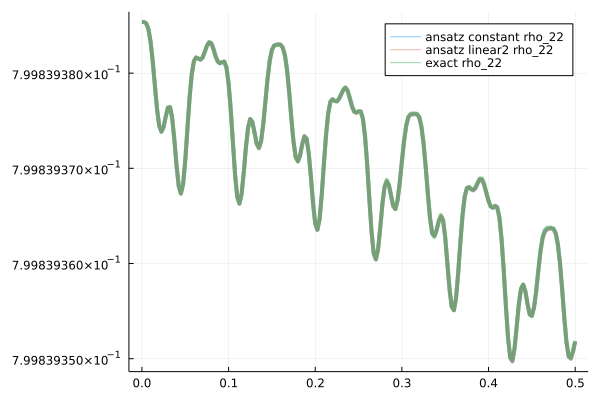

In [24]:

elLen = aggCore.molCount
rho_t = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t2 = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t_exact = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)

for t_i in 1:length(tspan)
    rho_t[t_i, :, :] = rho_int_t[t_i].data
    rho_t2[t_i, :, :] = rho_int_t2[t_i].data
    rho_t_exact[t_i, :, :] = trace_bath(W_t_exact[t_i, :, :], aggCore, aggTools)
    println(t_i, " ", D(rho_t[t_i, :, :], rho_t_exact[t_i, :, :]))
end

plot(tspan, real(rho_t2[:, 2, 2]), label="ansatz constant rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t[:, 2, 2]), label="ansatz linear2 rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t_exact[:, 2, 2]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)

(27, 27)
1 0.0
2 1.297672006546181e-11
3 4.1564829385988283e-11
4 7.330831924137171e-11
5 1.4508907399266147e-10
6 5.0421670768261727e-11
7 2.1784960993755374e-11
8 4.1374093315216716e-10
9 5.115863328523327e-10
10 3.252643594801089e-10
11 1.322097107577687e-9
12 7.749797554767969e-10
13 1.2241459207465663e-10
14 3.6582376680230885e-9
15 7.671621177469518e-10
16 1.8712726693965395e-9
17 1.6670040359404305e-9
18 3.3913134215383333e-9
19 2.4313839064858454e-9
20 1.3288130337706358e-9
21 2.7137132384017027e-9
22 2.9917598771956707e-9
23 3.937934165681189e-9
24 2.1619337645858355e-9
25 2.793609789225951e-9
26 4.312407010269621e-9
27 3.907570686938646e-9
28 4.214732897948103e-9
29 1.4117028999297483e-9
30 6.21365086649348e-9
31 3.421090085099245e-9
32 7.536106764513363e-9
33 1.8522469637135862e-9
34 5.200555789747177e-9
35 6.256515639019009e-9
36 5.7463063600107415e-9
37 7.149585643073808e-9
38 1.2329558621514238e-9
39 9.154441455024909e-9
40 5.966042479965278e-9
41 9.176059992310641e-9
42 

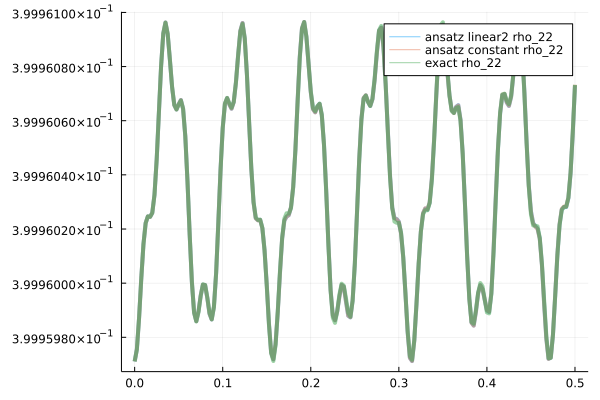

In [25]:
elLen = aggCore.molCount
rho_t = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t2 = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t_exact = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
println(size(Ham_0_Sinv))
for t_i in 1:length(tspan)
    t = tspan[t_i]
    U_op = evolutionOperator(Ham_sys, t)
    rho_t[t_i, :, :] = Ham_sys_Sinv * (U_op').data * rho_int_t[t_i].data * U_op.data * Ham_sys_S
    rho_t2[t_i, :, :] = Ham_sys_Sinv * (U_op').data * rho_int_t2[t_i].data * U_op.data * Ham_sys_S
    rho = trace_bath(W_t_exact[t_i, :, :], aggCore, aggTools)
    rho_t_exact[t_i, :, :] = Ham_sys_Sinv * (U_op').data * rho * U_op.data * Ham_sys_S
    println(t_i, " ", D(rho_t[t_i, :, :], rho_t_exact[t_i, :, :]))
end

plot(tspan, real(rho_t2[:, 2, 2]), label="ansatz linear2 rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t[:, 2, 2]), label="ansatz constant rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t_exact[:, 2, 2]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)

In [27]:
using OpenQuantumSystems
include("test_master_ansatz.jl")


Test Summary: |
master ansatz | No tests


Test.DefaultTestSet("master ansatz", Any[], 0, false, false)

In [71]:
names = [
    "test_operators_dense.jl",
    "test_superoperators.jl",
    "test_metrics.jl",
    "test_molecules.jl",
    "test_aggregateCore.jl",
    "test_aggregateTools.jl",
    "test_aggregateOperators.jl",
    "test_aggregate.jl",
    "test_evolution.jl",
    "test_schroedinger.jl",
    "test_liouville.jl",
    "test_interaction_picture.jl",
    "test_master_exact.jl",
    "test_trace.jl",
    "test_initial_state.jl",
    "test_memory_kernel.jl",
    "test_master_ansatz.jl",
]

for name in names
    include(name)
end

Test Summary:   | Pass  Total
operators dense |    6      6
Test Summary:  | Pass  Total
superoperators |    2      2
Test Summary: | Pass  Total
metrics       |   19     19
Test Summary: | Pass  Total
molecules     |   20     20
Test Summary: | Pass  Total
aggregateCore |   14     14
Test Summary:  | Pass  Total
aggregateTools |   12     12
Test Summary:      | Pass  Total
aggregateOperators |    7      7
Test Summary: | Pass  Total
aggregate     |    3      3
Test Summary: | Pass  Total
evolution     |   54     54
Test Summary: | Pass  Total
schroedinger  |   25     25
Test Summary: | Pass  Total
liouville     |   33     33
Test Summary:       | Pass  Total
interaction picture |   12     12
Test Summary: |
master        | No tests
Test Summary: | Pass  Total
trace         |   41     41
Test Summary: | Pass  Total
initial state |    8      8
Test Summary: | Pass  Total
memory kernel |   51     51
Test Summary: |
master ansatz | No tests
